In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

In [3]:
from __future__ import print_function, division

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [4]:
data_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data') 

In [5]:
labels = os.listdir(data_dir)

# Initialize labels encoder
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Create lists of files and labels for training (100'000 items)
files_data = []
labels_data = []
for label in labels:
    for filename in os.listdir(data_dir + '/' + label ):
        files_data.append(data_dir + '/' + label + '/' + filename)
        labels_data.append(label)

In [6]:
labels

['Non_violation', 'Violation']

In [7]:
print("The first five files from the list of train images:", files_data[:5])
print("\nThe first five labels from the list of train labels:", labels_data[:5])

The first five files from the list of train images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_2_2994144.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/Copy of _6_5523581.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_0_5482144.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_4_27430.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_11_1737337.jpg']

The first five labels from the list of train labels: ['Non_violation', 'Non_violation', 'Non_violation', 'Non_violation', 'Non_violation']


In [8]:
print(len(labels_data))

1289


In [9]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transforms, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train' or self.mode == 'val':
            x = self.transforms(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'test':
            x = self.transforms(pic)
            return x, self.files[index]

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    transforms.RandomErasing(p=0.5, scale=(0.06, 0.08), ratio=(1, 3), value=0, inplace=True)
])

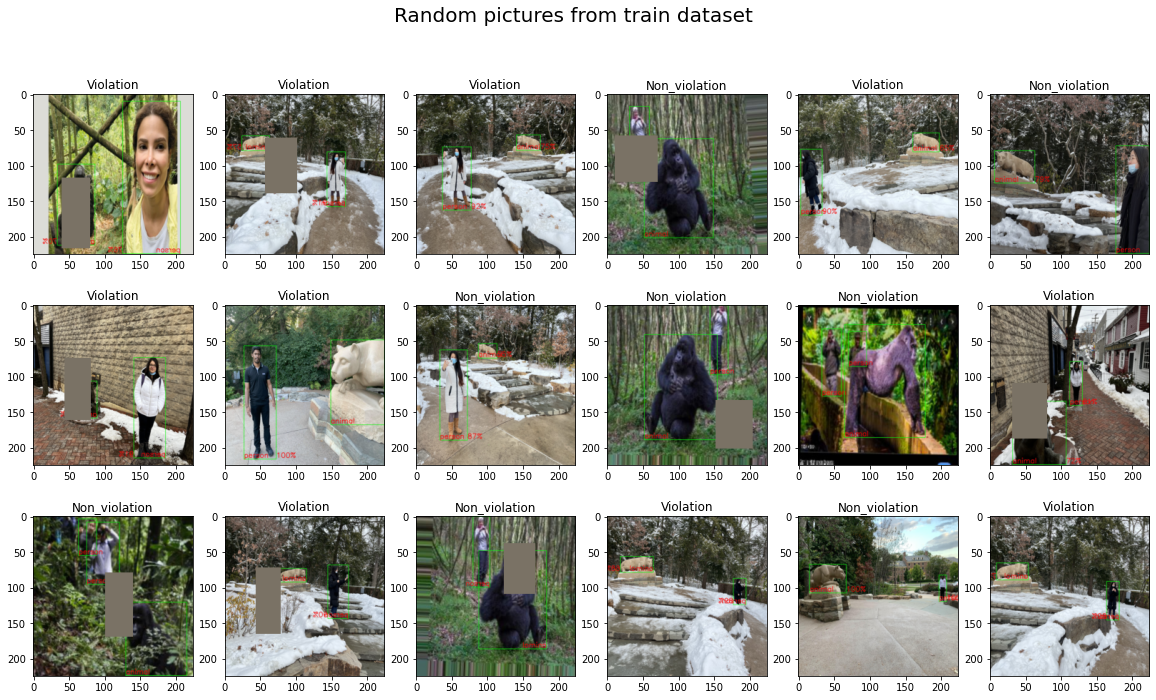

In [10]:

dataset = ImagesDataset(files=files_data,
                              labels=labels_data,
                              encoder=encoder_labels,
                              transforms=transforms_train,
                              mode='train')



fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Random pictures from train dataset', fontsize=20)
for ax in axs.flatten():
    n = np.random.randint(len(dataset))
    img = dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(encoder_labels.inverse_transform([dataset[n][1]])[0])
    ax.imshow(img)

In [11]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [900, 289, 100])

In [12]:
print(len(train_dataset),len(val_dataset), len(test_dataset))

900 289 100


In [13]:
labels_test = []
for i in range(len(test_dataset)):
  labels_test.append(encoder_labels.inverse_transform([test_dataset[i][1]])[0])

In [14]:
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

In [15]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):
    since = time.time()

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.009)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_last_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array
    
    
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
num_epochs = 25

In [17]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
model_densenet161 = models.densenet161()
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=2)
model_densenet161 = model_densenet161.to(DEVICE)
model_densenet161.load_state_dict(torch.load('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/code/JF/weights_v4/DenseNet161_weights.pth'))

<All keys matched successfully>

In [19]:
model_resnet50 = models.resnet50()
for param in model_resnet50.parameters():
    param.requires_grad = False
model_resnet50.fc = torch.nn.Linear(model_resnet50.fc.in_features, 2)
model_resnet50 = model_resnet50.to(DEVICE)
model_resnet50.load_state_dict(torch.load('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/code/JF/weights_v4/ResNet50_weights.pth'))

<All keys matched successfully>

In [20]:
model_resnet152 = models.resnet152()
for param in model_resnet152.parameters():
    param.requires_grad = False
model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 2)
model_resnet152 = model_resnet152.to(DEVICE)
model_resnet152.load_state_dict(torch.load('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/code/JF/weights_v4/ResNet152_weights.pth'))

<All keys matched successfully>

In [21]:
model_vgg16 = models.vgg16()
for param in model_vgg16.parameters():
    param.requires_grad = False
model_vgg16.classifier[6] = torch.nn.Linear(in_features=model_vgg16.classifier[6].in_features, out_features=2)
model_vgg16 = model_vgg16.to(DEVICE)
model_vgg16.load_state_dict(torch.load('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/code/JF/weights_v4/VGG16_weights.pth'))

<All keys matched successfully>

In [22]:
model_vgg19_bn = models.vgg19_bn()
for param in model_vgg19_bn.parameters():
    param.requires_grad = False
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=2)
model_vgg19_bn = model_vgg19_bn.to(DEVICE)
model_vgg19_bn.load_state_dict(torch.load('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/code/JF/weights_v4/VGG19_bn_weights.pth'))

<All keys matched successfully>

In [23]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB, modelC, modelD, modelE):
        super(EnsembleModel, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.modelD = modelD
        self.modelE = modelE

        #remove last linear layer
        # self.modelA.fc = nn.Identity()
        # self.modelB.fc = nn.Identity()
        # self.modelC.fc = nn.Identity()
        # self.modelD.fc = nn.Identity()
        # self.modelE.fc = nn.Identity()

        # create new classifier
        self.classifier = nn.Linear(2*5, 2)
        
    def forward(self, x):
        x1 = self.modelA(x.clone())
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x3 = self.modelC(x)
        x3 = x3.view(x3.size(0), -1)
        x4 = self.modelD(x)
        x4 = x4.view(x4.size(0), -1)
        x5 = self.modelE(x)
        x5 = x5.view(x4.size(0), -1)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_densenet161, model_resnet50, model_resnet152, model_vgg16, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(DEVICE)
ensemble_model.load_state_dict(torch.load('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/code/JF/weights_v4/Ensemble_weights.pth'))

<All keys matched successfully>

In [24]:
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)

all_preds = []
all_files = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_preds_decoded = encoder_labels.inverse_transform(all_preds)


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


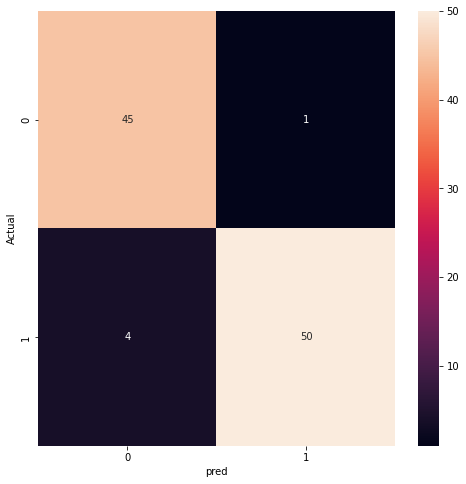

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test, all_preds_decoded)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [26]:
from sklearn.metrics import classification_report
matrix = classification_report(labels_test, all_preds_decoded,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.92      0.98      0.95        46
    Violation       0.98      0.93      0.95        54

     accuracy                           0.95       100
    macro avg       0.95      0.95      0.95       100
 weighted avg       0.95      0.95      0.95       100



test on other data

In [27]:
test2_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing')
test3_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Benchmark_validation') 

In [28]:
test4_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/other_animals')
test5_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/human_human')

In [29]:
# List of files for testing
files_test2 = []
labels_test2 = []
for label in labels:
  for filename in os.listdir(test2_dir + '/' + label):
      files_test2.append(test2_dir + '/' + label + '/' + filename)
      files_test2 = sorted(files_test2)
      labels_test2.append(label)

files_test3 = []
labels_test3 = []
for label in labels:
  for filename in os.listdir(test3_dir + '/' + label):
      files_test3.append(test3_dir + '/' + label + '/' + filename)
      files_test3 = sorted(files_test3)
      labels_test3.append(label)
files_test4 = []
labels_test4 = []
for label in labels:
  for filename in os.listdir(test4_dir + '/' + label):
      files_test4.append(test4_dir + '/' + label + '/' + filename)
      files_test4 = sorted(files_test4)
      labels_test4.append(label)

files_test5 = []
labels_test5 = []
for label in labels:
  for filename in os.listdir(test5_dir + '/' + label):
      files_test5.append(test5_dir + '/' + label + '/' + filename)
      files_test5 = sorted(files_test5)
      labels_test5.append(label)

In [30]:
print("\nThe first five files from the list of test images:", files_test2[:5])
print("\nThe first five labels from the list of test labels:", labels_test2[:5])
print("\nThe first five files from the list of test images:", files_test3[:5])
print("\nThe first five labels from the list of test labels:", labels_test3[:5])
print("\nThe first five files from the list of test images:", files_test4[:5])
print("\nThe first five labels from the list of test labels:", labels_test4[:5])
print("\nThe first five files from the list of test images:", files_test5[:5])
print("\nThe first five labels from the list of test labels:", labels_test5[:5])


The first five files from the list of test images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_2532090.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_2857314.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_4326839.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_6340112.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _2_1274240.jpg']

The first five labels from the list of test labels: ['Non_violation', 'Non_violation', 'Non_violation', 'Non_violation', 'Non_violation']

The first five files from the list of test images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Benchmark_validation/Non_violation/IMG_1736.JPG', '/content/gdrive/MyDrive/GTVD

In [31]:
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

In [32]:
test_dataset2 = ImagesDataset(files=files_test2,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')
test_dataset3 = ImagesDataset(files=files_test3,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')
test_dataset4 = ImagesDataset(files=files_test4,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')
test_dataset5 = ImagesDataset(files=files_test5,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')

In [33]:
print(len(test_dataset2),len(test_dataset3), len(test_dataset4),len(test_dataset5))

48 142 78 40


In [34]:
test_dataloader2 = DataLoader(test_dataset2, batch_size=8, shuffle=False)
test_dataloader3 = DataLoader(test_dataset3, batch_size=20, shuffle=False)
test_dataloader4 = DataLoader(test_dataset4, batch_size=16, shuffle=False)
test_dataloader5 = DataLoader(test_dataset5, batch_size=4, shuffle=False)

In [35]:
all_preds2 = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader2):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds2.extend(preds.tolist())

all_preds_decoded2 = encoder_labels.inverse_transform(all_preds2)


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


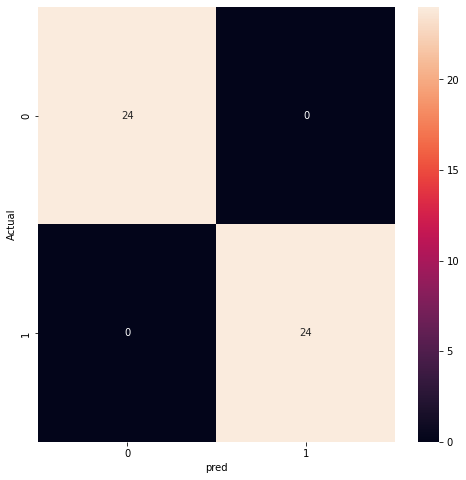

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test2, all_preds_decoded2)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [37]:
from sklearn.metrics import classification_report
matrix = classification_report(labels_test2, all_preds_decoded2,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       1.00      1.00      1.00        24
    Violation       1.00      1.00      1.00        24

     accuracy                           1.00        48
    macro avg       1.00      1.00      1.00        48
 weighted avg       1.00      1.00      1.00        48



In [38]:
all_preds3 = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader3):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds3.extend(preds.tolist())

all_preds_decoded3 = encoder_labels.inverse_transform(all_preds3)

100%|██████████| 8/8 [00:42<00:00,  5.31s/it]


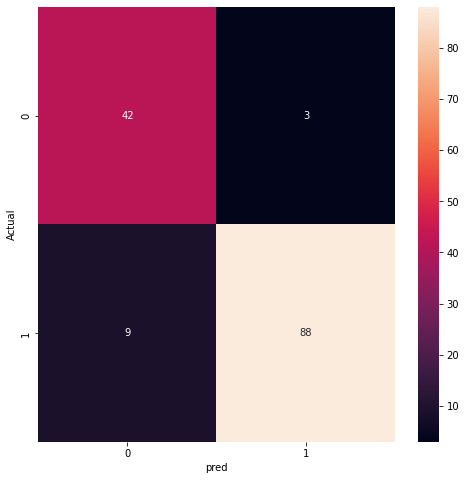

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test3, all_preds_decoded3)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [40]:
from sklearn.metrics import classification_report
matrix = classification_report(labels_test3, all_preds_decoded3,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.82      0.93      0.87        45
    Violation       0.97      0.91      0.94        97

     accuracy                           0.92       142
    macro avg       0.90      0.92      0.91       142
 weighted avg       0.92      0.92      0.92       142



In [41]:
all_preds4 = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader4):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds4.extend(preds.tolist())

all_preds_decoded4 = encoder_labels.inverse_transform(all_preds4)

100%|██████████| 5/5 [00:29<00:00,  5.89s/it]


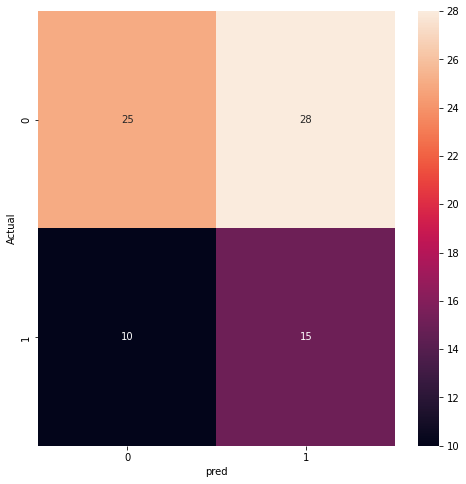

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test4, all_preds_decoded4)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [43]:
matrix = classification_report(labels_test4, all_preds_decoded4,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.71      0.47      0.57        53
    Violation       0.35      0.60      0.44        25

     accuracy                           0.51        78
    macro avg       0.53      0.54      0.50        78
 weighted avg       0.60      0.51      0.53        78



In [44]:
all_preds5 = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader5):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds5.extend(preds.tolist())

all_preds_decoded5 = encoder_labels.inverse_transform(all_preds5)

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


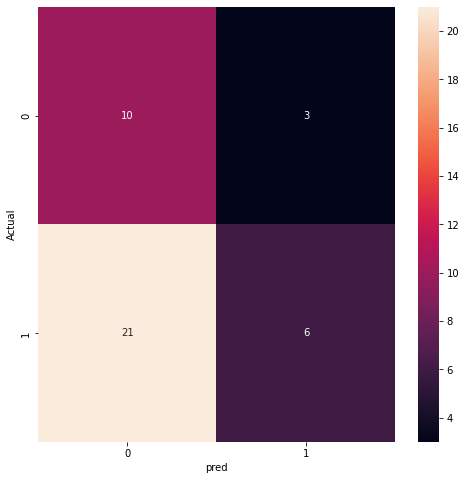

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test5, all_preds_decoded5)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [46]:
matrix = classification_report(labels_test5, all_preds_decoded5,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.32      0.77      0.45        13
    Violation       0.67      0.22      0.33        27

     accuracy                           0.40        40
    macro avg       0.49      0.50      0.39        40
 weighted avg       0.55      0.40      0.37        40

